In [60]:
%matplotlib inline
import os
os.chdir('U:\\GitHubClones\\SALTSeniorDesign')
os.getcwd()
import xlwings as xw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import re
from datetime import datetime

In [61]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [62]:
wb = xw.Book('Salt.xlsm')
setup = wb.sheets('Setup')
output = wb.sheets('Output')
strats = wb.sheets('Strat Tables')
performance = wb.sheets('Performance')
summ = wb.sheets('Summary')

# Path For the Current deal that is selected based on Setup
directory = setup['Setup.Directory'].value
shelf = setup['Setup.Shelf'].value
shelfList = setup['Shelf_List'].value
deal = setup['Setup.Deal'].value
report = setup['Setup.Report'].value
num_Deals = setup['Setup.Num_Deals'].value
max_Report = setup['Setup.Max_Report_Num'].value

In [63]:
tapes = np.array(setup['Tapes'].value)
tapes = tapes[0:int(max_Report),0:int(num_Deals)]
dfTapes = pd.DataFrame(data=tapes[1:,1:], columns=tapes[0,1:])
dealList = list(dfTapes.columns)

In [7]:
path = 'U:\AutoLoanTapes\\Drive Auto Receivables Trust\\DRIVE 2017-1\\' + dfTapes['DRIVE 2017-1'][0]
df = pd.read_csv(path, memory_map=True, low_memory=False)

In [103]:
groupDict = {
    'vehicleNewUsedCode':{
        1:'new',
        2:'used'
    },
    'vehicleTypeCode':{
        1:'Car',
        2:'Truck',
        3:'SUV',
        4:'Motorcycle',
        98:'Other',
        99:'Unknown'
    },
    'subvented':{
        0:'Not Subvented',
        1:'Rate Subvention',
        2:'Cash Subvention',
        3:'Rate & Cash Subvention',
        98:'Other Subvention'
    },
    'obligorIncomeVerificationLevelCode':{
    1:'Not Stated, Not Verified',
    2:'Stated, Not Verified',
    3:'Stated, Verified',
    4:'Stated, Verified: 12 M',
    5:'Stated, Verified: 24 M'
    },
    'obligorEmploymentVerificationCode':{
    1:'Not Stated, Not Verified',
    2:'Stated, Not Verified',
    3:'Stated, Third Party Verified'
    }
    #'vehicleValueAmount': 
}

In [104]:
def vehicleStats(metrics, data, mappingDict):
    WA = lambda x: np.average(x, axis=0, weights = data.loc[x.index, 'reportingPeriodActualEndBalanceAmount'])
    data['pctDeal'] = (data['reportingPeriodActualEndBalanceAmount']/(data['reportingPeriodActualEndBalanceAmount'].sum()))
    data['LTV'] = (data['originalLoanAmount']/data['vehicleValueAmount']) #Loan to value ratio
    row = 2
    col = 'A'
    dfVehicleStats = pd.DataFrame()
    for i in range(0, len(metrics)):
        if metrics[i] in ['vehicleNewUsedCode', 'vehicleModelYear', 'vehicleTypeCode', 'vehicleValueAmount']:
            data[metrics[i]] = pd.to_numeric(data[metrics[i]], errors='coerce')
        if metrics[i] in['vehicleManufacturerName', 'vehicleModelName', 'obligorGeographicLocation', 'vehicleModelYear']:
            summ.range(col + str(row)).options(pd.DataFrame, header=False).value = (data[['pctDeal']].groupby(data[metrics[i]]).sum()).sort_values(['pctDeal'], ascending=False).head(3)
            dfNew = (data[['pctDeal']].groupby(data[metrics[i]]).sum()).sort_values(['pctDeal'], ascending=False).head(3)
            del dfNew.index.name
            print(dfNew)
            row = row + len(dfNew.index) + 1
            if metrics[i] == 'vehicleModelYear':
                yearRange = [str(data[metrics[i]].min()) + '-' + str(data[metrics[i]].max())]
                summ.range(col + str(row)).options(pd.DataFrame, header=False).value = pd.DataFrame(yearRange, index=['Model Year Range'])
                dfYearRange = pd.DataFrame(yearRange, index=['Model Year Range'])
                print(dfYearRange)
                #summ.range('A'+ str(count)).value = dfYearRange
                row = row + len(dfYearRange.index) + 1
            continue
        else:
            summ.range(col + str(row)).options(pd.DataFrame, header=False).value = data[['pctDeal']].groupby(data[metrics[i]]).sum().rename(index=groupDict[metrics[i]])
            stats = data[['pctDeal']].groupby(data[metrics[i]]).sum().rename(index=groupDict[metrics[i]])
            del stats.index.name
            print(stats)
            row = row + len(stats.index) + 1

def creditStats(metrics, data, mappingDict):
    row = 14
    col = 'D'
    WA = lambda x: np.average(x, axis=0, weights = data.loc[x.index, 'reportingPeriodActualEndBalanceAmount'])
    data['pctDeal'] = (data['reportingPeriodActualEndBalanceAmount']/(data['reportingPeriodActualEndBalanceAmount'].sum()))
    data['LTV'] = (data['originalLoanAmount']/data['vehicleValueAmount']) #Loan to value ratio
    creditLis = []
    for i in range(0, len(metrics)):
        data[metrics[i]] = pd.to_numeric(data[metrics[i]], errors='coerce')
        if metrics[i] == 'subvented':
            data[metrics[i]] = data[metrics[i]].fillna(3)
            summ.range(col + str(row)).options(pd.DataFrame, header=False).value = data[['pctDeal']].groupby(data[metrics[i]]).sum().rename(index=groupDict[metrics[i]]).head(3)
            stats = data[['pctDeal']].groupby(data[metrics[i]]).sum().rename(index=groupDict[metrics[i]]).head(3)
            row = row + len(stats.index) + 1
            del stats.index.name
            print(stats)
            continue
        creditLis.append([WA(data[metrics[i]])])
    summ.range('E' + str(row)).value = creditLis
    row = row + len(creditLis) + 1
    return creditLis #original term, remaining term, original interenst rate, LTV

def obligorStats(metrics, data, mappingDict):
    WA = lambda x: np.average(x, axis=0, weights = data.loc[x.index, 'reportingPeriodActualEndBalanceAmount'])
    data['pctDeal'] = (data['reportingPeriodActualEndBalanceAmount']/(data['reportingPeriodActualEndBalanceAmount'].sum()))
    data['LTV'] = (data['originalLoanAmount']/data['vehicleValueAmount']) #Loan to value ratio
    row = 2
    col = 'D'
    obligorLis = []
    for i in range(0,len(metrics)):
        data[metrics[i]] = pd.to_numeric(data[metrics[i]], errors='coerce')
        if metrics[i] == 'obligorCreditScore':
            noScore = (data[metrics[i]].isnull().sum()/len(data))
            obligorLis.append([noScore])
            newData = data[['obligorCreditScore', 'pctDeal']].dropna()
            obligorLis.append([WA(newData[metrics[i]])])
            continue
        if metrics[i] in['obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode']:
            summ.range(col + str(row)).options(pd.DataFrame, header=False).value = data[['pctDeal']].groupby(data[metrics[i]]).sum().rename(index=groupDict[metrics[i]]).sort_values(['pctDeal'], ascending=False)
            dfNew = data[['pctDeal']].groupby(data[metrics[i]]).sum().rename(index=groupDict[metrics[i]]).sort_values(['pctDeal'], ascending=False)
            row = row + len(dfNew.index) + 1
            del dfNew.index.name
            print(dfNew)
            continue
        obligorLis.append([WA(data[metrics[i]])]) #1:percentage of no score, 2: WA Credit Score, 3: WA PTI
    summ.range('E' + str(row)).value = obligorLis
    row = row + len(obligorLis) + 1
    return obligorLis

In [105]:
obligorMetrics = ['obligorCreditScore', 'obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode','paymentToIncomePercentage']
creditMetrics = ['originalLoanTerm', 'remainingTermToMaturityNumber','originalInterestRatePercentage','LTV','subvented']
vehicleMetrics = ['vehicleNewUsedCode', 'vehicleManufacturerName','vehicleModelName', 'vehicleModelYear','vehicleTypeCode',
                  'obligorGeographicLocation']
vehicleStats(vehicleMetrics, df, groupDict)
creditStats(creditMetrics,df,groupDict)
obligorStats(obligorMetrics,df,groupDict)

       pctDeal
new   0.240876
used  0.759124
            pctDeal
NISSAN     0.137297
TOYOTA     0.084443
CHEVROLET  0.079362
           pctDeal
Altima    0.042619
Ram 1500  0.030562
Sentra    0.029728
       pctDeal
2017  0.189518
2014  0.177302
2016  0.154054
                          0
Model Year Range  2002-2018
        pctDeal
Car    0.599776
Truck  0.125816
SUV    0.274409
     pctDeal
TX  0.157021
FL  0.111069
GA  0.074982
                  pctDeal
Not Subvented    0.974983
Rate Subvention  0.024131
Cash Subvention  0.000037
                       pctDeal
Stated, Not Verified  0.841028
Stated, Verified      0.158972
                               pctDeal
Stated, Not Verified          0.814000
Stated, Third Party Verified  0.132861
Not Stated, Not Verified      0.053138


[[0.1499082295748797], [569.5344102212631], [0.11302517202692673]]

In [28]:
stratDict = {
    'Fico Score':{
        'bin':[-1, 440, 500, 560, 620, 680, 740, 800, 1000],
        'label':['[-1, 440)', '[440, 500)', '[500, 560)', '[560, 620)', '[620, 680)', '[680, 740)', '[740, 800)', '[800, 1000)'],
        'index':['0 - 440', '441 - 500', '501 - 560', '561 - 620', '621 - 680', '681 - 740', '741 - 800', '801 +'],
        'histBin':100
    },
    'APR':{
        'bin':[0, .04, .08, .12, .16, .20, .24, .28, 1000],
        'label':['[0.0, 0.04)', '[0.04, 0.08)', '[0.08, 0.12)', '[0.12, 0.16)', '[0.16, 0.20)', '[0.20, 0.24)', '[0.24, 0.28)', '[0.28, 1000)'],
        'index': ['0.00% - 4.00%', '4.01% - 8.00%', '8.01% - 12.00%', '12.01% - 16.00%','16.01% - 20.00%', '20.01% - 24.00%', '24.01% - 28.00%', '28.00% +'],
        'histBin':75
    },
    'LTV':{
        'bin':[-1, .7, .8, .9, 1, 1.1, 1.2, 1.3, 1.4, 1000],
        'label':['[-1.0, 0.7)', '[0.7, 0.8)', '[0.8, 0.9)', '[0.9, 1.0)', '[1.0, 1.1)','[1.1, 1.2)', '[1.2, 1.3)', '[1.3, 1.4)', '[1.4, 1000)'],
        'index':['0.00% - 70.00%', '70.01% - 80.00%', '80.01% - 90.00%', '90.01% - 100.00%', '100.01% - 110.00%','110.01% - 120.00%', '120.01% - 130.00%', '130.01% - 140.00%', '140.01% +'],
        'histBin':100
        #['[-1.0, 0.7)', '[0.7, 0.8)', '[0.8, 0.9)', '[0.9, 1.0)', '[1.0, 1.1)','[1.1, 1.2)', '[1.2, 1.3)', '[1.3, 1.4)', '[1.4, 1000.0)']
    },
    'PTI':{
        'bin':[-1, .02, .04, .06, .08, .1, .12, .14, .16, 1000],
        'label':['[-1.0, 0.02)', '[0.02, 0.04)', '[0.04, 0.06)', '[0.06, 0.08)','[0.08, 0.1)', '[0.1, 0.12)', '[0.12, 0.14)', '[0.14, 0.16)', '[0.16, 1000)'],
        'index':['0.00% - 2.00%', '2.01% - 4.00%', '4.01% - 6.00%', '6.01% - 8.00%','8.01% - 10.00%', '10.01% - 12.00%', '12.01% - 14.00%','14.01% - 16.00%', '16.01% +'],
        'histBib':100
#['[-1.0, 0.02)', '[0.02, 0.04)', '[0.04, 0.06)', '[0.06, 0.08)','[0.08, 0.1)', '[0.1, 0.12)', '[0.12, 0.14)', '[0.14, 0.16)', '[0.16, 1000.0)']
    }
}

In [29]:
def stratTable(data, stratDict):
    data  = data[data.zeroBalanceCode.isin(['-'])]
    WA = lambda x: np.average(x, axis=0, weights = data.loc[x.index, 'reportingPeriodActualEndBalanceAmount'])
    data['pctDeal'] = (data['reportingPeriodActualEndBalanceAmount']/(data['reportingPeriodActualEndBalanceAmount'].sum()))
    data['LTV'] = (data['originalLoanAmount']/data['vehicleValueAmount']) #Loan to value ratio
    
    a = OrderedDict([
    ('assetNumber',['count']),
    ('reportingPeriodActualEndBalanceAmount', ['sum','mean']),
    ('pctDeal', ['sum']),
    ('originalLoanTerm',[WA]),
    ('remainingTermToMaturityNumber',[WA]),
    ('paymentToIncomePercentage',[WA]),
    #('LTV',[WA]),
    ('originalInterestRatePercentage',[WA]),
    ('currentDelinquencyStatus',['mean'])
    ])
    
    keyList = list(stratDict.keys())
    colsKeyList = list(a.keys())
    stratMetrics = ['obligorCreditScore', 'originalInterestRatePercentage', 'LTV', 'paymentToIncomePercentage']
    row = 3
    row2 = 3
    for i in range(0, len(stratMetrics)):
        data[stratMetrics[i]] = pd.to_numeric(data[stratMetrics[i]], errors='coerce')
        data[keyList[i]] = pd.cut(data[stratMetrics[i]], stratDict[keyList[i]]['bin'], right=True, labels=stratDict[keyList[i]]['label'])
        if stratMetrics[i] == 'obligorCreditScore':
            data[keyList[i]] = data[keyList[i]].cat.add_categories('No Score').fillna('No Score')
        summ.range('i' + str(row)).options(pd.DataFrame, header=False).value = data[colsKeyList].groupby(by=[data[keyList[i]]]).agg(a)
        stratTable = data[colsKeyList].groupby(by=[data[keyList[i]]]).agg(a)
        
        #stratTable = stratTable.reindex(keyList[i]['label'])
        print(stratTable)
        row = row + len(stratTable.index) + 2
        

In [30]:
stratTable(df, stratDict)

            assetNumber reportingPeriodActualEndBalanceAmount                 pctDeal originalLoanTerm remainingTermToMaturityNumber paymentToIncomePercentage originalInterestRatePercentage currentDelinquencyStatus
                  count                                   sum          mean       sum         <lambda>                      <lambda>                  <lambda>                       <lambda>                     mean
Fico Score                                                                                                                                                                                                            
[-1, 440)          1096                          1.663741e+07  15180.120055  0.012033        69.325972                     67.315559                  0.103495                       0.219376                 2.641423
[440, 500)         9111                          1.414698e+08  15527.365081  0.102316        69.634695                     66.960610        

In [23]:
df['LTV'] = (df['originalLoanAmount']/df['vehicleValueAmount'])
df['LTV'].describe()

count    80636.000000
mean         1.086395
std          0.163898
min          0.073481
25%          0.990132
50%          1.098139
75%          1.197387
max          1.598735
Name: LTV, dtype: float64

TypeError: Don't know what to do with that image object

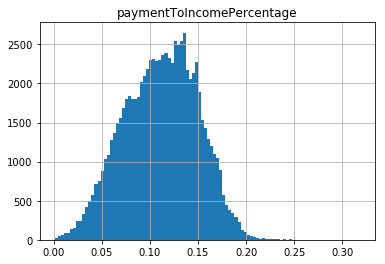

In [73]:
lis = ['obligorCreditScore', 'originalInterestRatePercentage', 'LTV', 'paymentToIncomePercentage']
df['obligorCreditScore'] = pd.to_numeric(df['obligorCreditScore'], errors='coerce') 
fig = df.hist(column='paymentToIncomePercentage', bins=100)
rng = summ.range('A27')
summ.pictures.add(fig, name='PTI', update=True)

In [54]:
def histogram(data):
    binDict = {
        'obligorCreditScore':{
            'bin':100,
            'name': 'Fico Score Histogram'
        },
        'originalInterestRatePercentage':{
            'bin':75,
            'name':'APRHistogram'
        },
        'LTV':{
            'bin':100,
            'name':'LTV Histogram'
        },
        'paymentToIncomePercentage':{
            'bin':100,
            'name':'PTI Histogram'
        }
    }
    lis = list(binDict.keys())
    print(lis)
    for i in range(0,len(lis)):
        fig = data.hist(column=lis[i], bins=binDict[lis[i]]['bin'])
        
        summ.pictures.add(fig, name=binDict[lis[i]]['name'], update=True,
                          left=summ.range('B5').left, top=summ.range('B5').top)

['obligorCreditScore', 'originalInterestRatePercentage', 'LTV', 'paymentToIncomePercentage']


TypeError: Don't know what to do with that image object

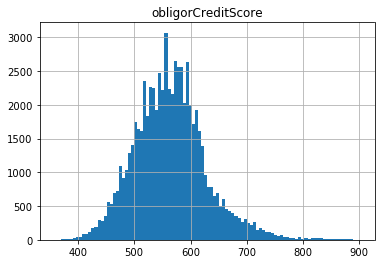

In [55]:
histogram(df)